In [1]:
# This is version 3.10 for smFISH spot detection. I have tried using pycharm + other python platform but in the end I feel like using Jupyter notebook is more suitable 
# Especailly for person who enter the Planarian Field might not understand coding/structure and other things too much. 
# This requires a enviornment and setting parameters. 
# https://stackoverflow.com/questions/58645807/change-interpreter-in-jupyter-notebook Please refer to this for setting up python interpreter. 
# This requires setting up a enviornment for 3D detection on stardist and bigfish. 
# Recommend to setup a enviornment for Stardist and then install bigfish/fishquant. 
# Please read instructions from Stardist to do so, and set python interpreter using the stackoverflow instructions. 
# Depend on your Image and settings this whole code need a while to run. I am making it as light as possible so please be patient. 
# I am also using tqdm in all of my customized code to show you process and the expected time in real time. 
# Please contact qingxuguan2020@u.northwestern.edu for any details/updates/help. 

In [2]:
controlImage = True
custom_model = True
modelDirectory = "/Users/eliasguan/Desktop/models"
controlPath = None
smFISHChannelPath = "/Volumes/Backup Plus/314_analysis_results/Experiment/0hr_Amputation/Image3/565/0h_Amputation_Image3_565.tif"
nucleiChannelPath = "/Volumes/Backup Plus/314_analysis_results/Experiment/0hr_Amputation/Image3/405/0h_Amputation_Image3_405.tif"
nuclei_projection_size = 7
# Set your thresh hold for stardist segmentation 
detection_thresh = (0.35,0.3)
# If the image is normalized (i.e normalized from CSBdeep or other method, use True, or use False)
normalizedImage = False
# Change your normalize threshold here. If it is True previously, you dont need to change it. 
normalize_thresh = (0.1, 99.9)
# Run all then you are good.
# Do you want to use a custo trained model here. 
# Here if you need to have a custom model the system will ask you for a custom model directory
custom_model = True
# Here select your random sample percentage in z-stack for nuclei segmentation estimation. 0 -100 is the percentage range, 100% means each z-stack will be selected and sampled. 
samplePercentage = 100
# Here select your random sample region size for nuclei segmentation estimation. 500X5000 means 500 X 500 pixel in each z-stack will be selected
sampleRegionSize = (500,500)
# Here set the nuclei label expanding radius
labelExpansionSize = 20

In [3]:
# This part is for importing all the functions for smFISH detection. Please install them if you dont have these pacakges. 
import os
import sys
# import tk for getting the directory faster. dont need this in a command line/server version
import numpy as np
import glob
from tifffile import imread, imwrite
import bigfish.detection 
import bigfish.stack
import bigfish.plot
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import random
import math
import json
# if you dont need to plot in jupyter you don need these. Some magic interperters need to be removed for command line version. 
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# csb deep is to take normalization 
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
# This is your stardist models and everything in stardist coming from. 
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from skimage import segmentation
import bigfish.multistack as multistack
# Set random seed for you color map. You do not really need this to be 6 all the time, but its okay. 
np.random.seed(6)
lbl_cmap = random_label_cmap()

In [4]:
def load_npy_file(filename):
    try:
        data = np.load(filename)
        print(f"Loaded {filename} successfully.")
        return data
    except FileNotFoundError:
        print(f"{filename} not found.")
    except Exception as e:
        print(f"Error loading {filename}: {e}")
    return None
def make_stardist_Predictions_labels (dataset, normalized = False, normalize_low = 0, normalize_high = 0, nms_thresh = 0, prob_thresh = 0): 
    ''' input: csbdeep input: If this image is a csbdeep filtered image. If this is true, the image will not be normalized. 
               dataset: The data set you want to analysis on 
               normalize_low and normalized_high: The parameter you want to normalize, if either of them is 0 will use default value (1,99.8)
               if not then will use these values 
               nms_thresh and prob_thrsh : the parameter of overlapping and probablity threshold. If eitehr of them is 0 will use default value 
               for the model (depend on the model) if not then use these values
    '''
    labels_collection= []
    for i in range(len(dataset)): 
        if not normalized:
            if normalize_low ==0 or normalize_high == 0:
                img = normalize(dataset[i], 1,99.8, axis=(0,1))
            else:
                img = normalize(dataset[i], normalize_low, normalize_high, axis=(0,1))
        else:
            img = dataset[i]
        if nms_thresh == 0 or prob_thresh == 0 :
            labels, details = model.predict_instances(img)
        else: 
            labels, details = model.predict_instances(img,nms_thresh = nms_thresh, prob_thresh = prob_thresh)
        # write labels
        labels_collection.append(labels)
        export_imagej_rois('polygons/polygon_rois_'+str(i).zfill(3)+'.zip', details['coord'])
        imwrite("labels/Nucleus_Labels_"+str(i).zfill(3)+".tif", labels)
    labels_collection = np.array(labels_collection, dtype = np.uint16)
    return labels_collection
def random_select_images(dataset, percentage):
    """
    Randomly select a certain percentage of images from the dataset.

    Parameters:
        dataset (list): A list containing 2D arrays (images).
        percentage (float): Percentage of images to be selected.

    Returns:
        selected_indices (list): A list of indices corresponding to the selected images.
    """
    num_images = len(dataset)
    num_selected = int(np.ceil(percentage/100 * num_images))
    selected_indices = np.random.choice(num_images, num_selected, replace=False)
    return selected_indices

def random_select_region(image, region_size):
    """
    Randomly select a region within the image with a certain size.

    Parameters:
        image (2D array): The original image.
        region_size (tuple): The size of the region to be selected (height, width).

    Returns:
        region (2D array): The selected region.
    """
    image_height, image_width = image.shape
    region_height, region_width = region_size

    if region_height > image_height or region_width > image_width:
        raise ValueError("Region size exceeds original image size.")

    start_row = np.random.randint(0, image_height - region_height + 1)
    start_col = np.random.randint(0, image_width - region_width + 1)
    end_row = start_row + region_height
    end_col = start_col + region_width

    region_prop = [(start_row, end_row),(start_col,end_col)]
    return region_prop
def make_random_examples(dataset, normalize_low = 0, normalize_high =0, nms_thresh =0, prob_thresh = 0, normalized = False, percentage = 20, region_size = (500,500)):
    selected_indicies = sorted(random_select_images(dataset, percentage))
    for item in selected_indicies: 
        if normalized:
            img = dataset[item]
        else:
            if normalize_low ==0 or normalize_high == 0:
                img = normalize(dataset[item], 1,99.8, axis=(0,1))
            else:
                img = normalize(dataset[item], normalize_low, normalize_high, axis=(0,1))   
        if nms_thresh == 0 or prob_thresh == 0 :
            labels, details = model.predict_instances(img)
        else: 
            labels, details = model.predict_instances(img, nms_thresh = nms_thresh, prob_thresh = prob_thresh)
        region_props =  random_select_region(img, region_size)
        cropped_image = img[region_props[0][0]:region_props[0][1],region_props[1][0]:region_props[1][1]]
        cropped_label = labels[region_props[0][0]:region_props[0][1],region_props[1][0]:region_props[1][1]]
        figure = plt.figure(figsize=(13,10))
        coord, points, prob = details['coord'], details['points'], details['prob']
        # Plot image on the first one
        ax1 = figure.add_subplot(121); ax1.imshow(cropped_image, cmap='gray'); ax1.axis('off')
        # Plot image on the second one
        ax2 = figure.add_subplot(122); ax2.imshow(cropped_image, cmap='gray'); ax2.axis('off')
        # Plot labels on the third one. 
        ax2.imshow(cropped_label, cmap=lbl_cmap, alpha=0.3)
        figure.tight_layout()
        plt.savefig("random_examples/random_example_"+str(item).zfill(3)+".tif")
def create_folder_in_same_directory(file_path, folder_name):
    """
    Creates a folder with the specified name in the same directory as the given file.
    If the folder already exists, it returns the existing path.
    """
    # Get the directory of the given file
    directory = os.path.dirname(file_path)
    
    # Define the path for the specified folder
    folder_path = os.path.join(directory, folder_name)
    
    # Check if the folder exists
    if not os.path.exists(folder_path):
        # Create the folder if it doesn't exist
        os.makedirs(folder_path)
        print(f"Created '{folder_name}' folder at: {folder_path}")
    else:
        print(f"'{folder_name}' folder already exists at: {folder_path}")
    
    return folder_path
def generate_max_projection_array(array, projection_size):
    ranges = []
    total = array.shape[0]
    projected_image = []
    for i in range(0, total, projection_size):
        start = i
        end = min(i + projection_size - 1, total - 1)
        ranges.append((start, end))
    for item in ranges:
        start, end = item
        nuclei_array = []
        for i in range(start,end):
            nuclei_array.append(array[i])
        if len(nuclei_array) >=2:
            projection = bigfish.stack.maximum_projection(np.array(nuclei_array,dtype=np.uint8))
        else: 
            projection = array[start]
        projected_image.append(projection)
    return np.array(projected_image,dtype=np.uint8)

In [5]:
resultsPath = os.path.dirname(smFISHChannelPath)+"/results"
# First read in spots: 
os.chdir(resultsPath)
# File names
file_A = 'spots_post_decomposition_and_background_removed.npy'
file_B = 'spots_post_decomposition.npy'

# Try loading A, fallback to B if A fails
post_decomposition_array = load_npy_file(file_A)
if post_decomposition_array is None:
    post_decomposition_array = load_npy_file(file_B)

Loaded spots_post_decomposition_and_background_removed.npy successfully.


In [6]:
nucleiImageArray = imread(nucleiChannelPath)
nucleiImageArray_projected = generate_max_projection_array(nucleiImageArray, projection_size = nuclei_projection_size)
imwrite('nuclei_projection.tif',nucleiImageArray_projected, photometric = 'minisblack')
if custom_model:
    model = StarDist2D(None, name='stardist_2D', basedir=modelDirectory)
else: 
    model = StarDist2D.from_pretrained('2D_versatile_fluo')
create_folder_in_same_directory('.','labels')
create_folder_in_same_directory('.','polygons')
create_folder_in_same_directory('.','random_examples')

2025-03-26 19:23:51.143147: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-03-26 19:23:51.143169: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-03-26 19:23:51.143174: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-03-26 19:23:51.143391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-26 19:23:51.143590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.492714, nms_thresh=0.3.
'labels' folder already exists at: labels
'polygons' folder already exists at: polygons
'random_examples' folder already exists at: random_examples


'random_examples'

2025-03-26 19:23:52.531728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


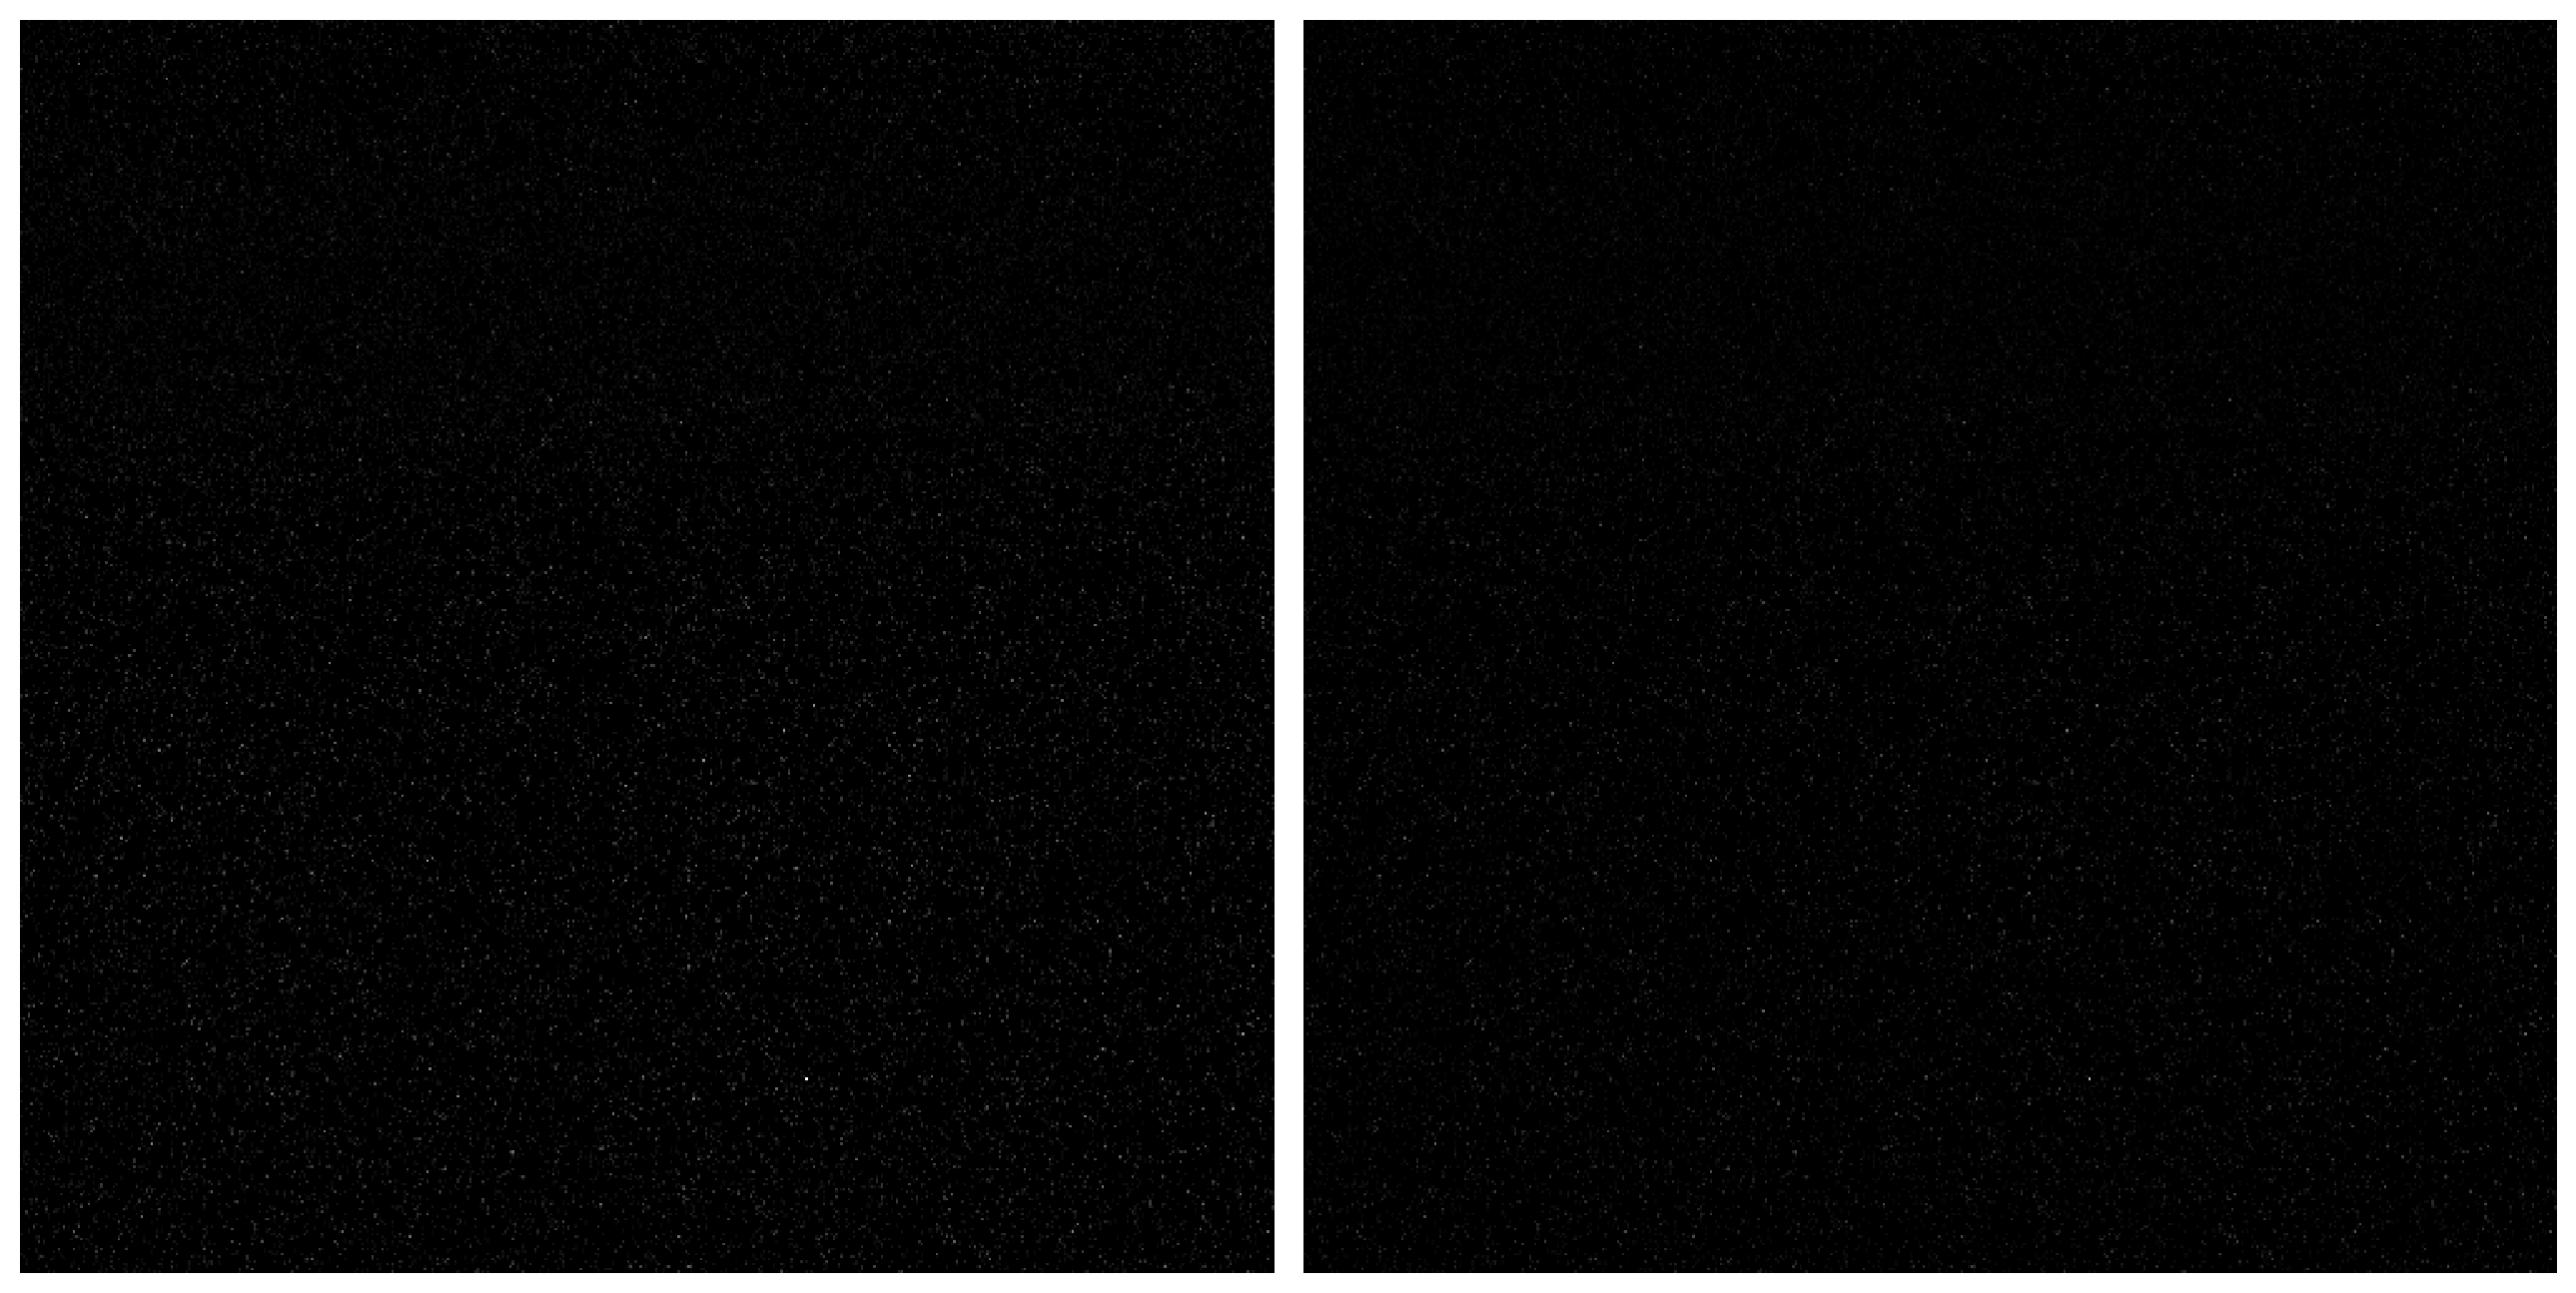

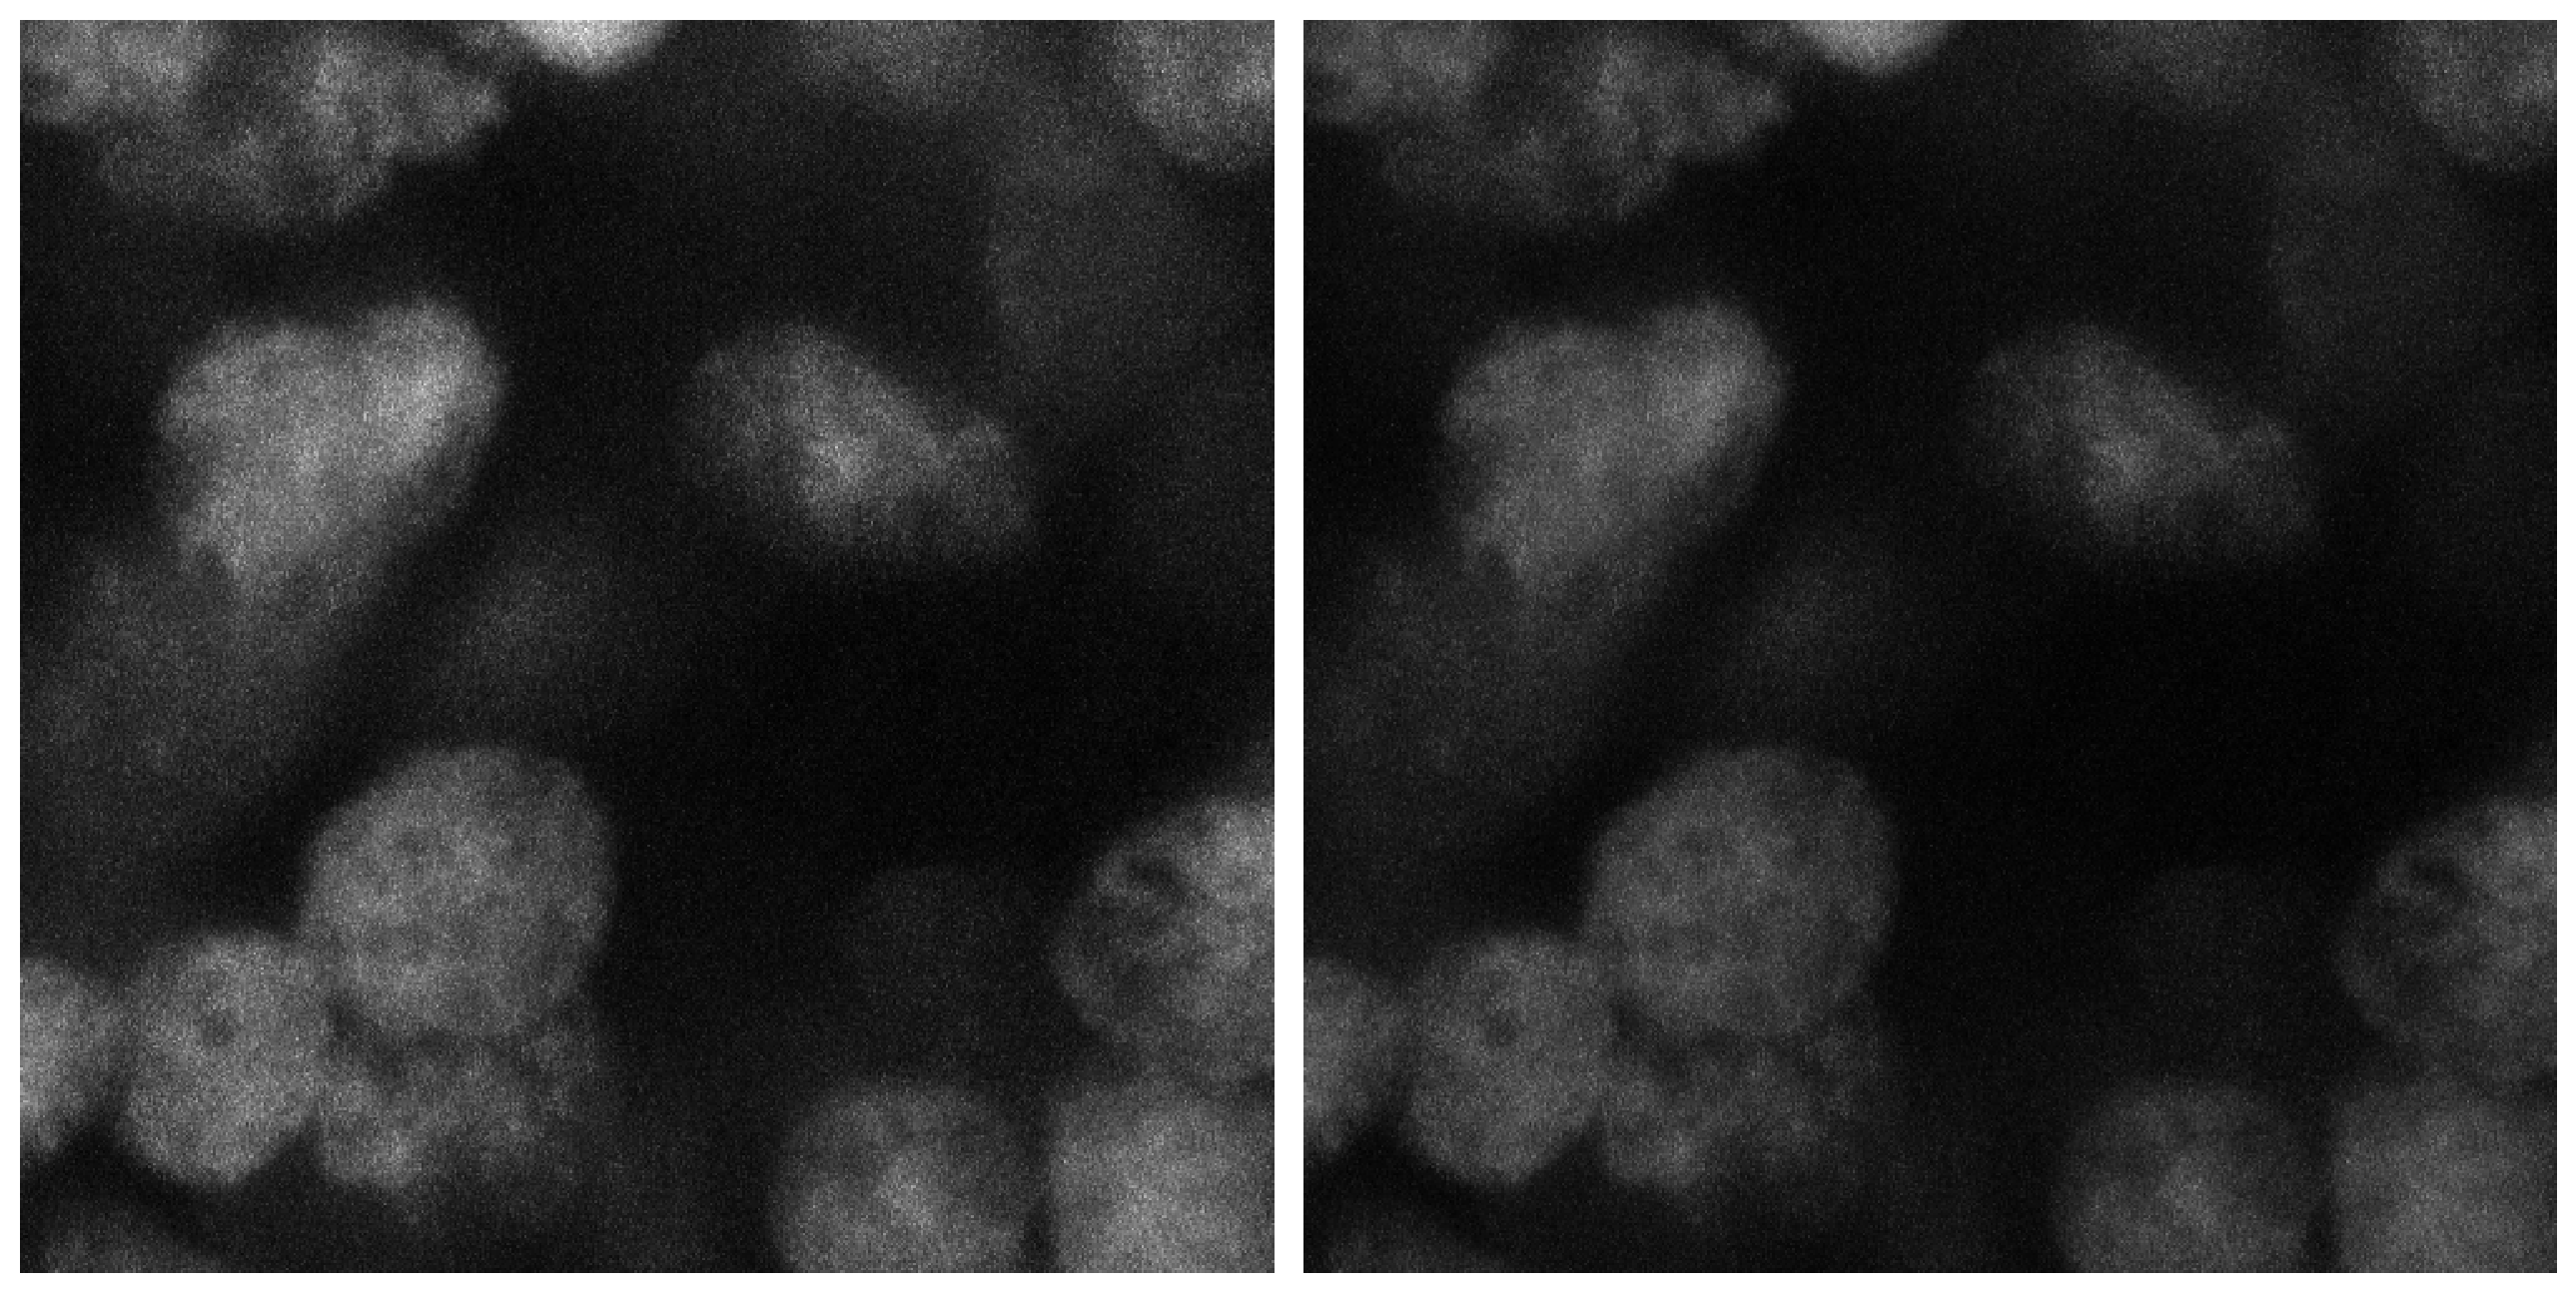

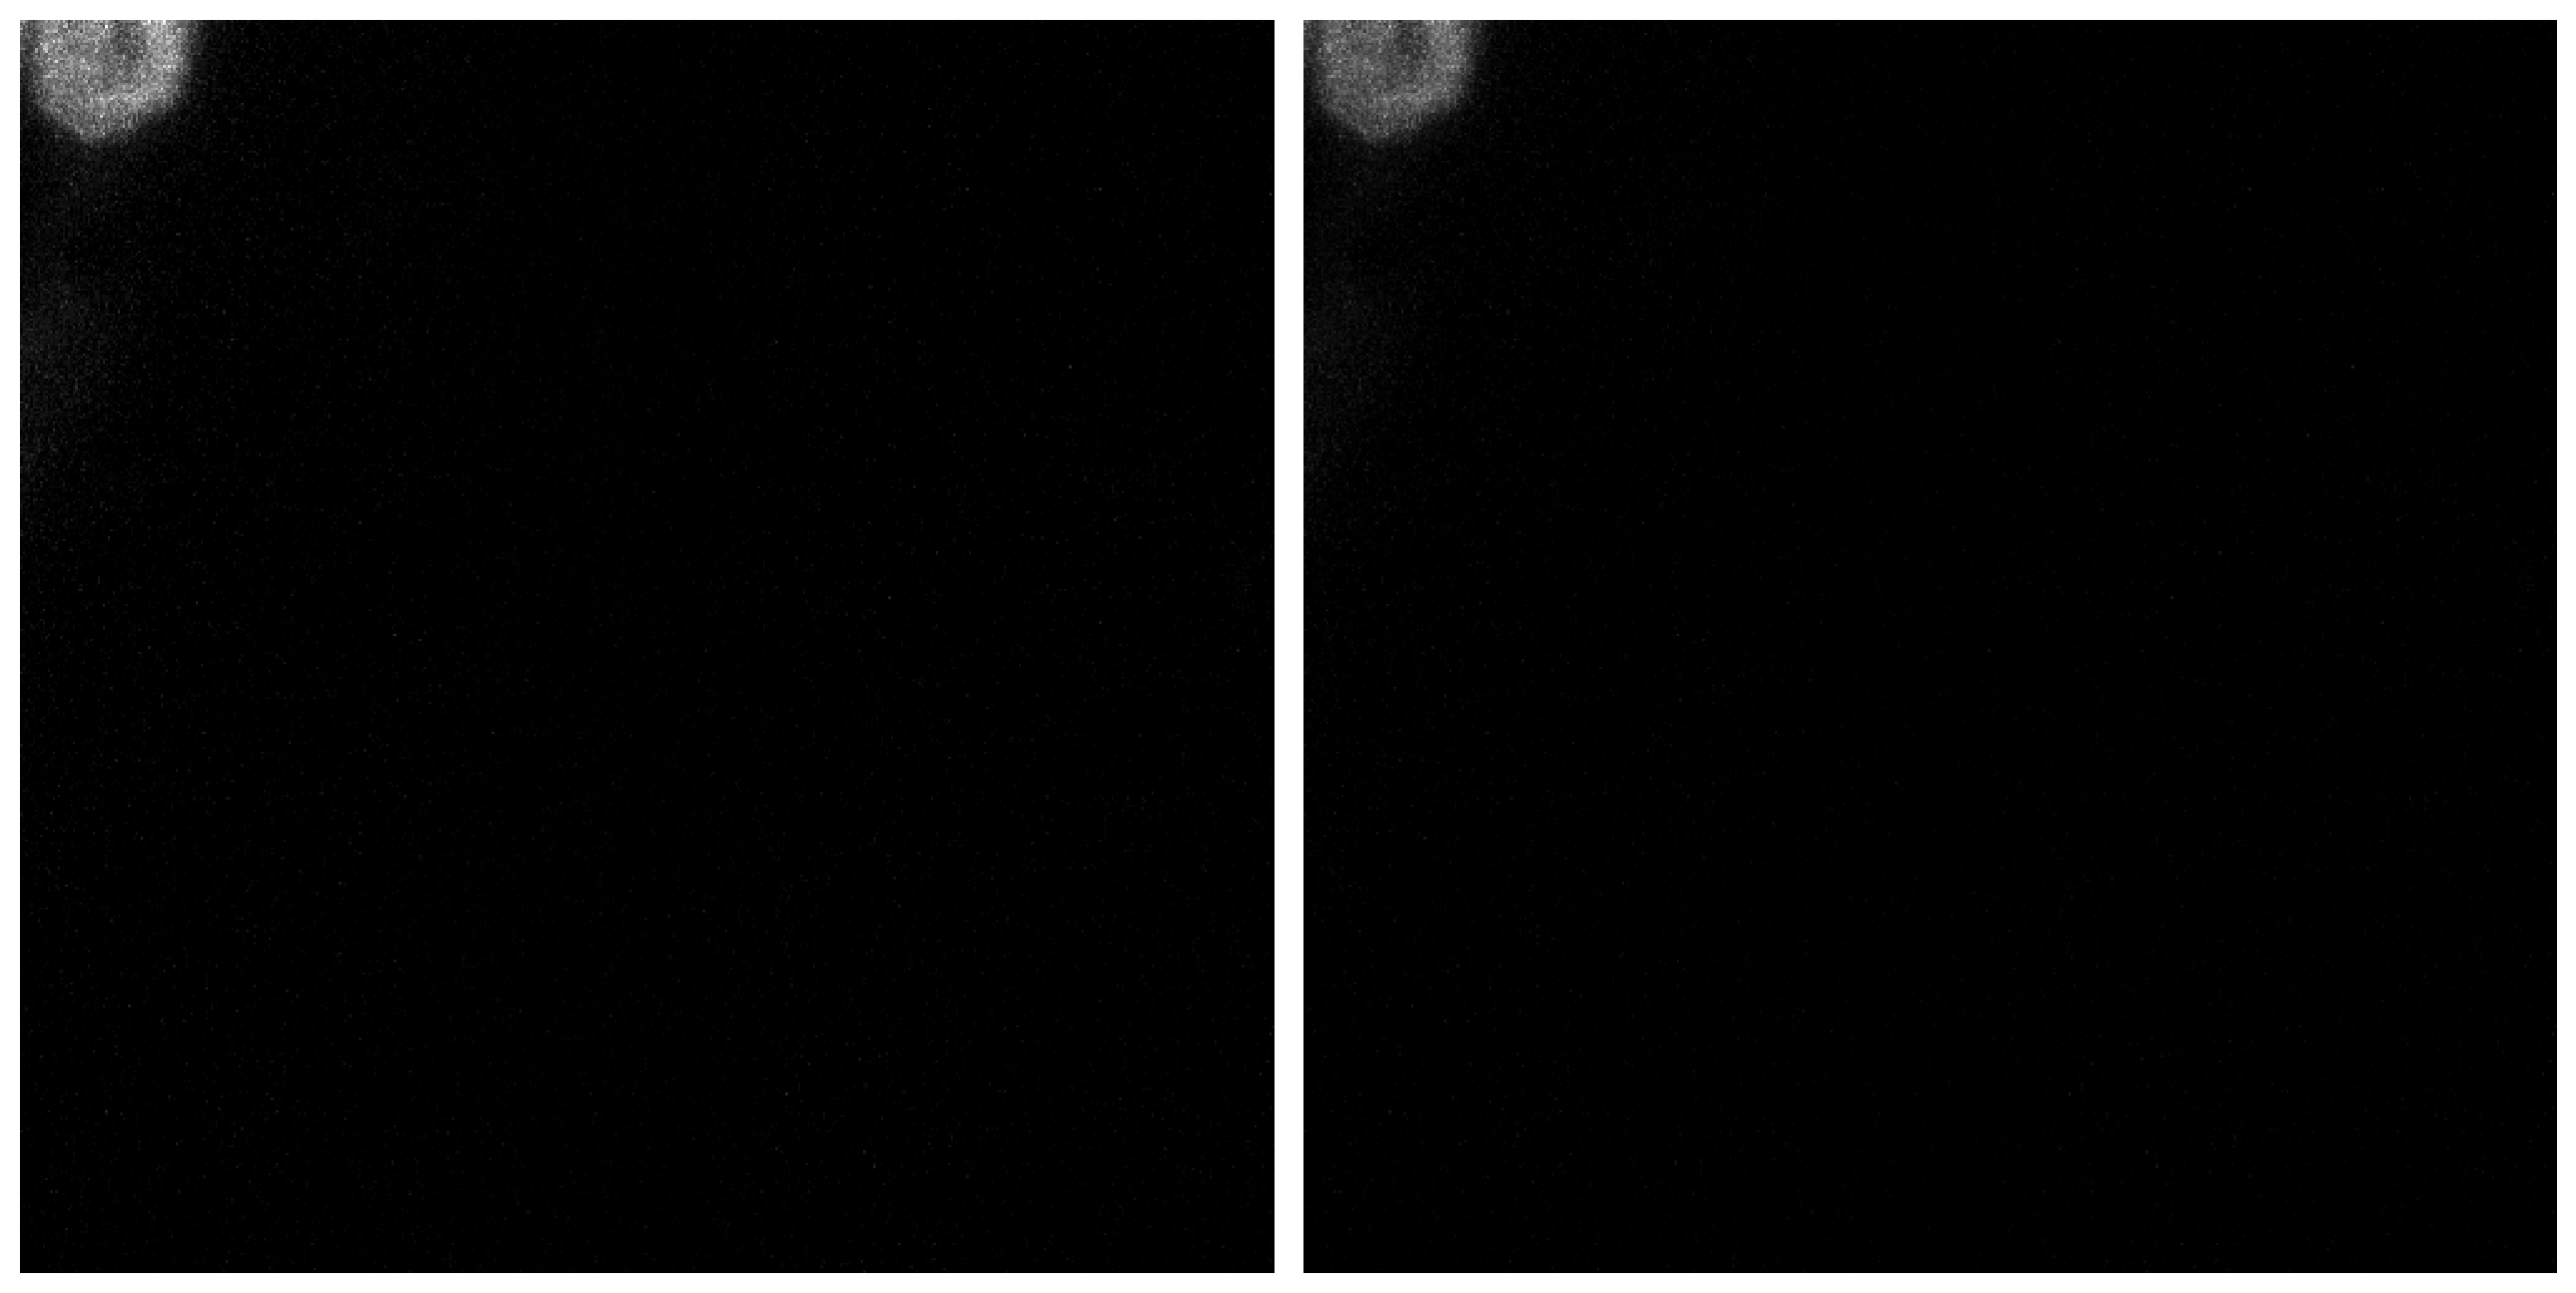

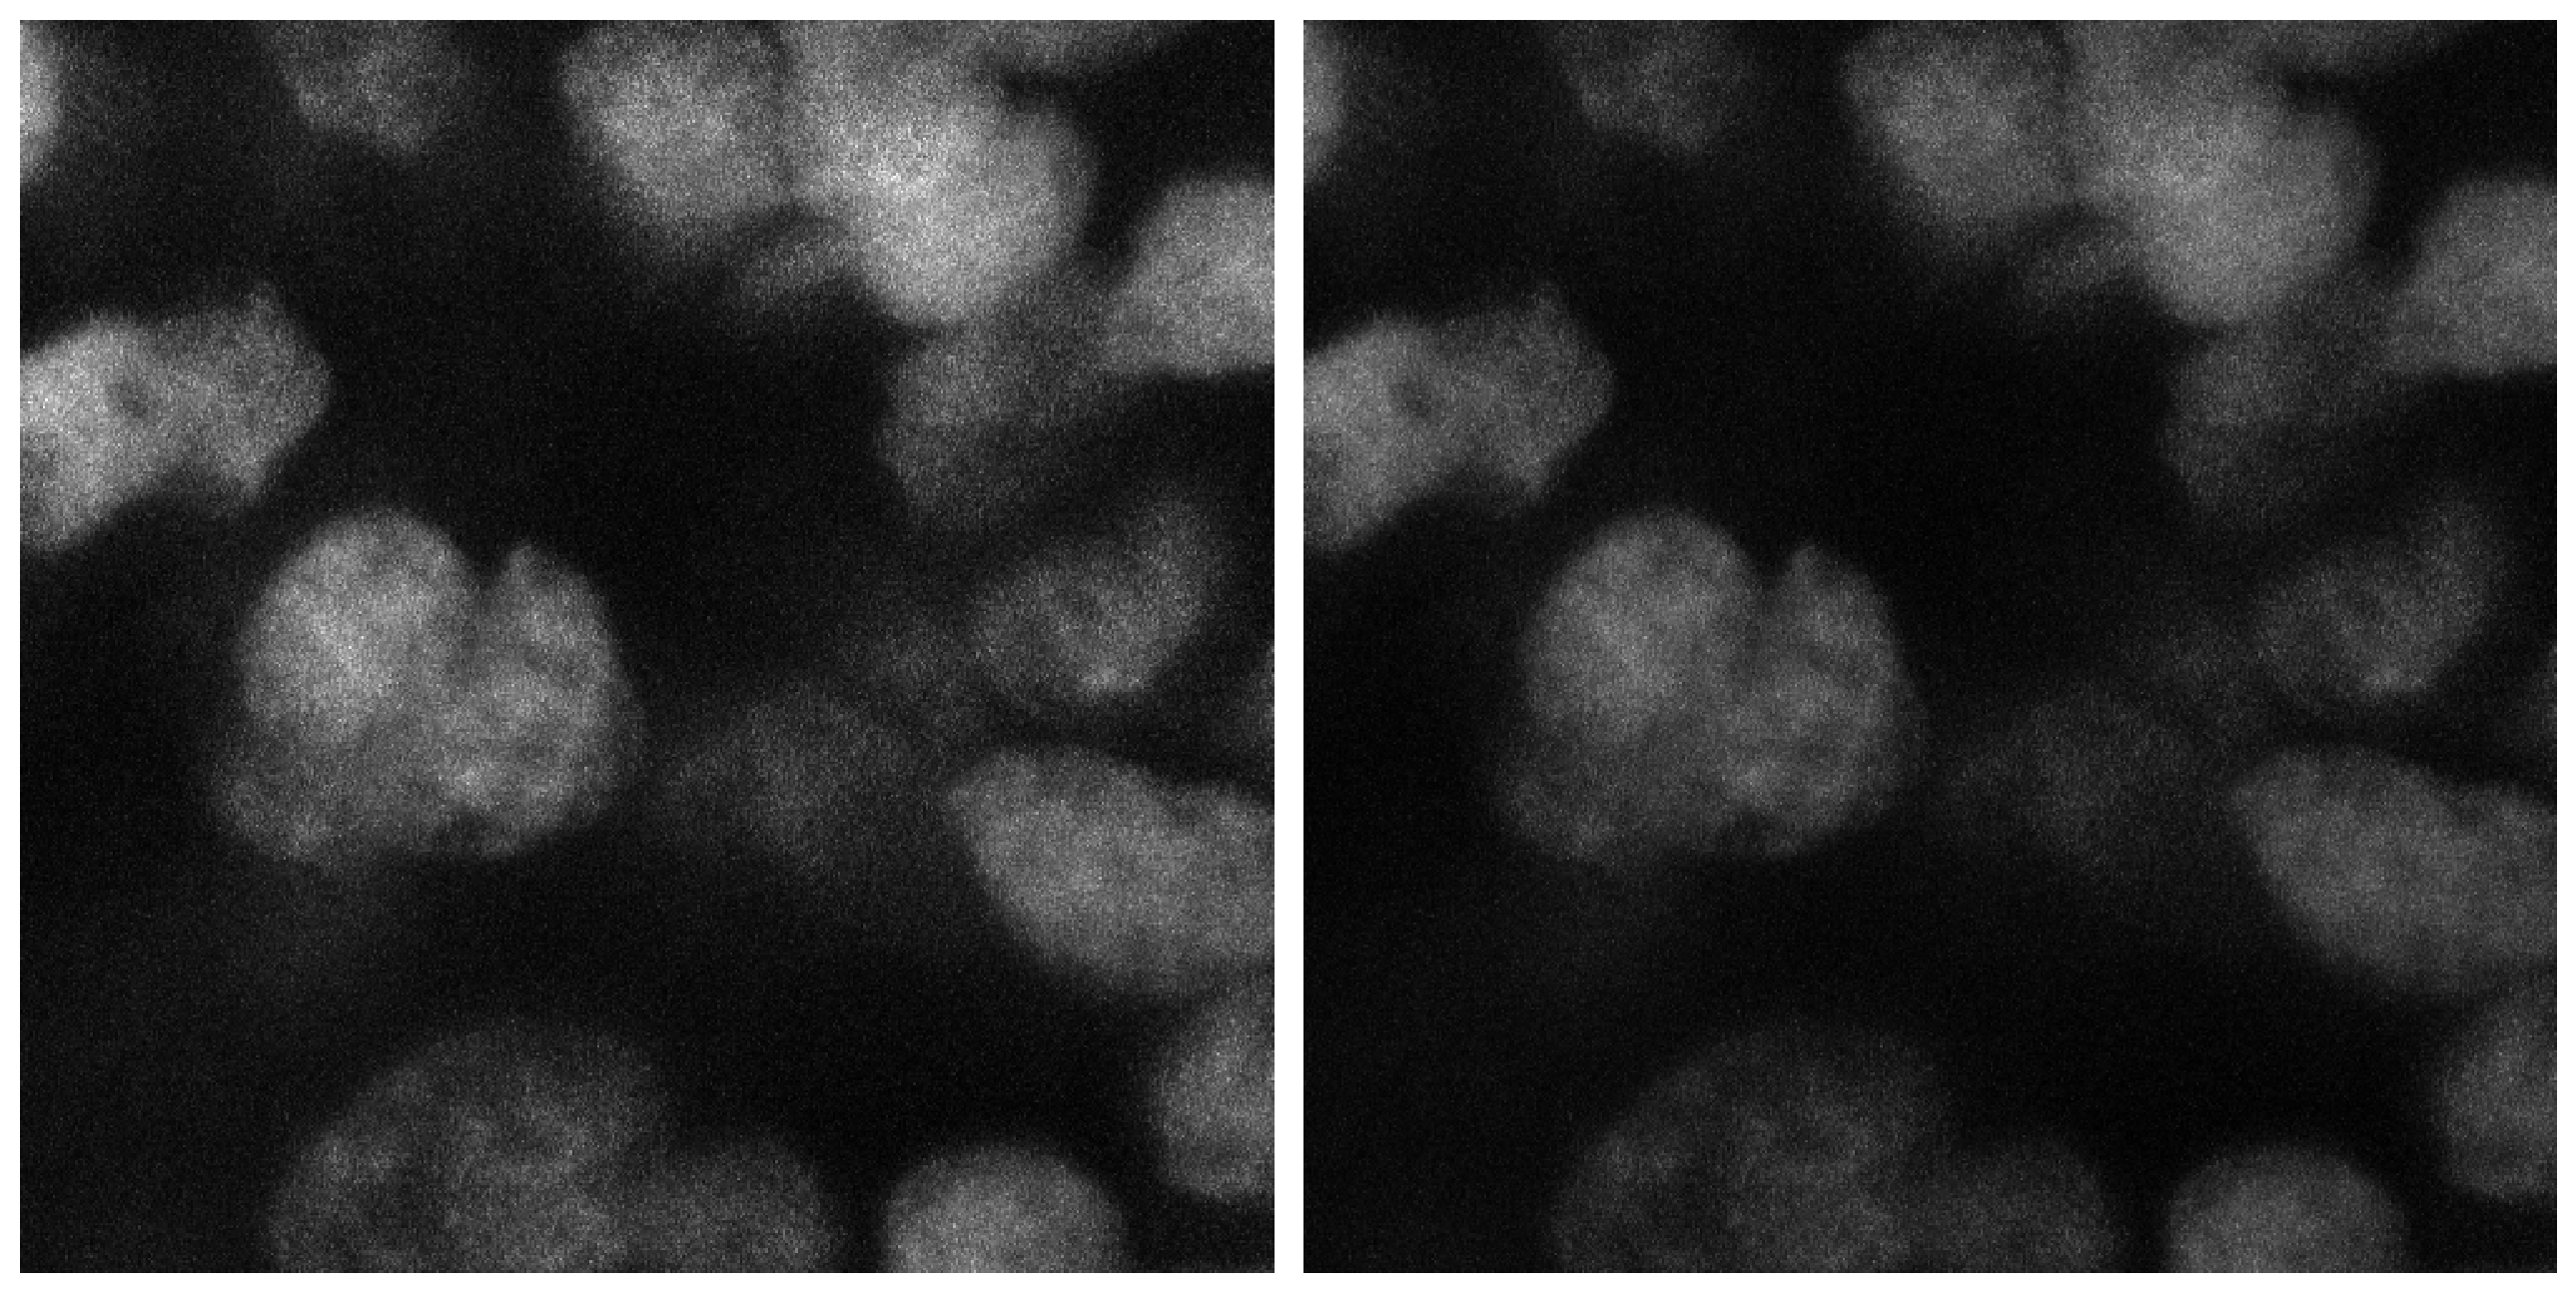

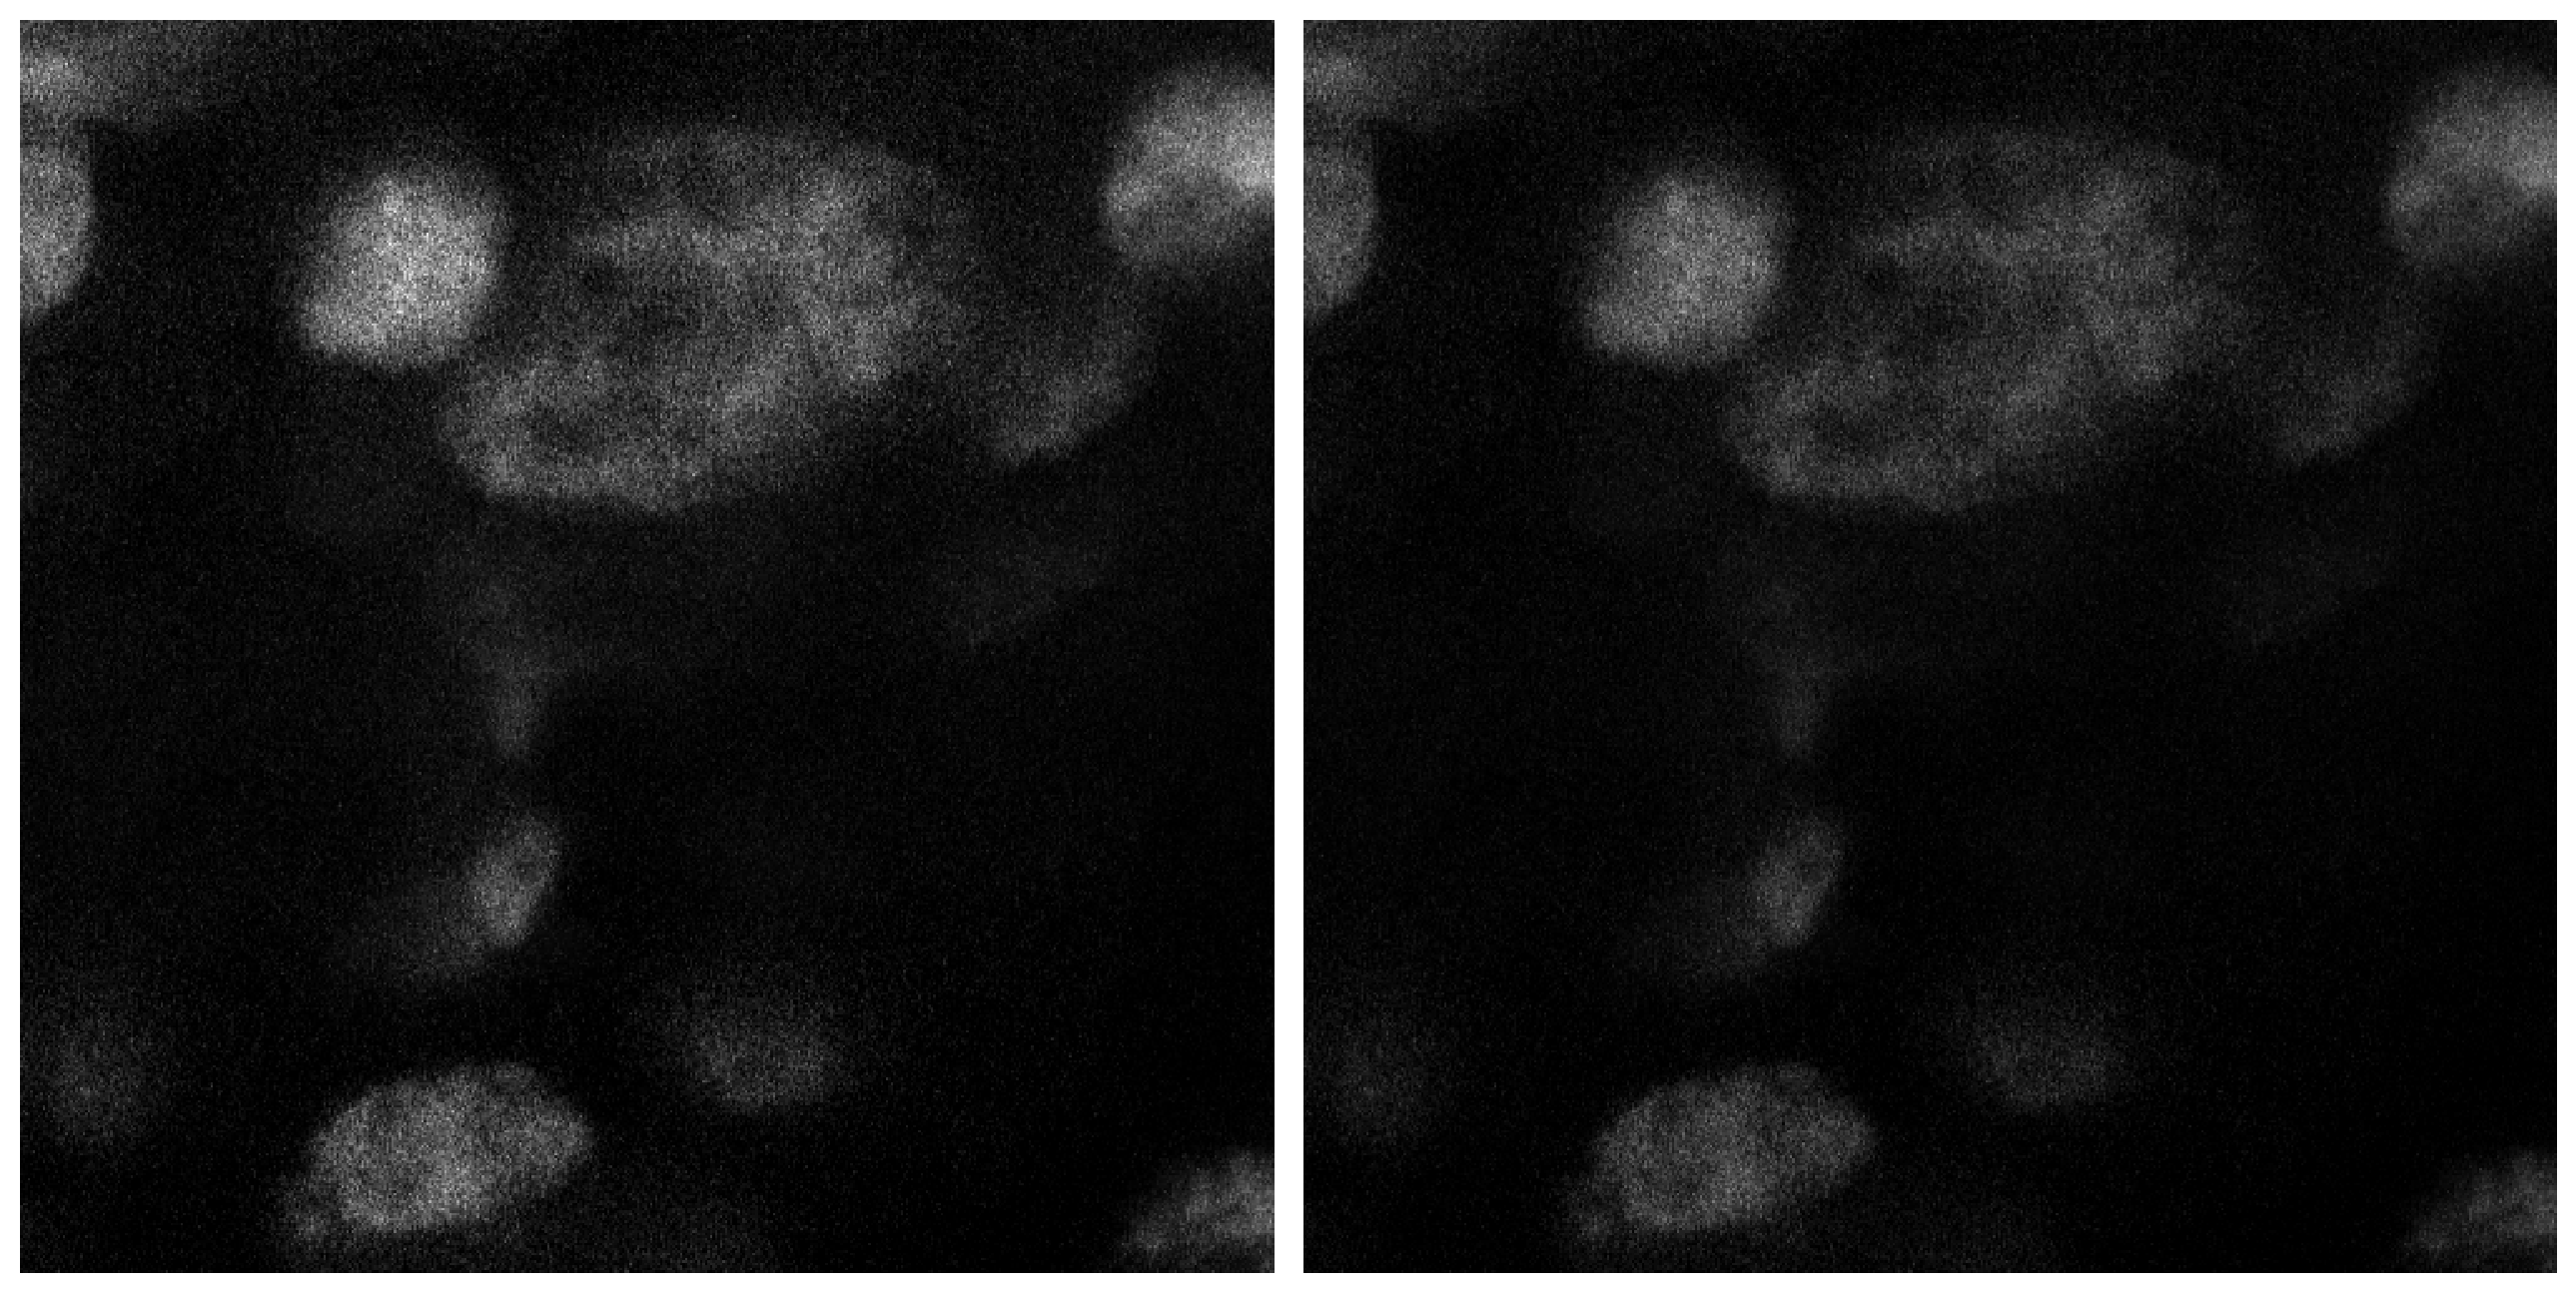

In [7]:
nucleiImageArray_projected_labels = make_stardist_Predictions_labels(nucleiImageArray_projected, normalized = normalizedImage, normalize_low = normalize_thresh[0], normalize_high = normalize_thresh[1], nms_thresh = detection_thresh[0], prob_thresh = detection_thresh[1])
make_random_examples(nucleiImageArray_projected, normalized = normalizedImage, normalize_low = normalize_thresh[0], normalize_high = normalize_thresh[1], nms_thresh = detection_thresh[0], prob_thresh = detection_thresh[1], percentage = samplePercentage, region_size = sampleRegionSize)